<a href="https://colab.research.google.com/github/yashraj195/Olist_ecommerce_analysis/blob/main/MLmodel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Shipping Performance Analysis for E-commerce**

##**Loading Data**

In [1]:
import pandas as pd

customers = pd.read_csv("olist_customers_dataset.csv")
geolocation = pd.read_csv("olist_geolocation_dataset.csv")
order_items = pd.read_csv("olist_order_items_dataset.csv")
order_payments = pd.read_csv("olist_order_payments_dataset.csv")
order_reviews = pd.read_csv("olist_order_reviews_dataset.csv")
orders = pd.read_csv("olist_orders_dataset.csv")
products = pd.read_csv("olist_products_dataset.csv")
sellers = pd.read_csv("olist_sellers_dataset.csv")
product_category_translation = pd.read_csv("product_category_name_translation.csv")

###**Data Preprocessing**

In [2]:
orders.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13 00:00:00
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04 00:00:00
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15 00:00:00
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26 00:00:00


In [3]:
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99441 entries, 0 to 99440
Data columns (total 8 columns):
 #   Column                         Non-Null Count  Dtype 
---  ------                         --------------  ----- 
 0   order_id                       99441 non-null  object
 1   customer_id                    99441 non-null  object
 2   order_status                   99441 non-null  object
 3   order_purchase_timestamp       99441 non-null  object
 4   order_approved_at              99281 non-null  object
 5   order_delivered_carrier_date   97658 non-null  object
 6   order_delivered_customer_date  96476 non-null  object
 7   order_estimated_delivery_date  99441 non-null  object
dtypes: object(8)
memory usage: 6.1+ MB


In [4]:
cols_to_datetime = [
    'order_purchase_timestamp',
    'order_approved_at',
    'order_delivered_carrier_date',
    'order_delivered_customer_date',
    'order_estimated_delivery_date'
]

orders[cols_to_datetime] = orders[cols_to_datetime].apply(pd.to_datetime)
orders.dtypes

,0
order_id,object
customer_id,object
order_status,object
order_purchase_timestamp,datetime64[ns]
order_approved_at,datetime64[ns]
order_delivered_carrier_date,datetime64[ns]
order_delivered_customer_date,datetime64[ns]
order_estimated_delivery_date,datetime64[ns]


In [5]:
orders[['order_delivered_customer_date','order_estimated_delivery_date']].isnull().sum()

,0
order_delivered_customer_date,2965
order_estimated_delivery_date,0


Cases where customer delivery date is null so we need to drop it

In [6]:
filtered_orders = orders.dropna(subset=['order_delivered_customer_date','order_estimated_delivery_date']).copy()
filtered_orders[['order_delivered_customer_date','order_estimated_delivery_date']].isnull().sum()

,0
order_delivered_customer_date,0
order_estimated_delivery_date,0


Check again we see that order_delivered_customer_date has no NA value now.

In [7]:
filtered_orders['delivery_delay'] = (filtered_orders['order_delivered_customer_date']-filtered_orders['order_estimated_delivery_date']).dt.days
filtered_orders['delayed'] = filtered_orders['delivery_delay'] >0

In [8]:
filtered_orders.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,delivery_delay,delayed
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18,-8,False
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13,-6,False
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04,-18,False
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15,-13,False
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26,-10,False


##**Exploratory Data Analysis (EDA)**

###**Orders Analysis**

In [9]:
filtered_orders['delayed'].value_counts(normalize=True)*100

,proportion
delayed,
False,93.226295
True,6.773705


From above , we can see that 6.7% of all orders are delayed

###**City Analysis**

In [10]:
order_customer_df = filtered_orders.merge(customers,on='customer_id')
order_customer_df.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,delivery_delay,delayed,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18,-8,False,7c396fd4830fd04220f754e42b4e5bff,3149,sao paulo,SP
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13,-6,False,af07308b275d755c9edb36a90c618231,47813,barreiras,BA
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04,-18,False,3a653a41f6f9fc3d2a113cf8398680e8,75265,vianopolis,GO
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15,-13,False,7c142cf63193a1473d2e66489a9ae977,59296,sao goncalo do amarante,RN
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26,-10,False,72632f0f9dd73dfee390c9b22eb56dd6,9195,santo andre,SP


In [11]:
delayed_by_city = order_customer_df[order_customer_df['delayed']==True]['customer_city'].value_counts()
delayed_by_city = delayed_by_city.reset_index() #reset the index to turn it into DataFrame
delayed_by_city.columns=['customer_city','delay_count'] #rename the columns
delayed_by_city.head()

,customer_city,delay_count
0,sao paulo,715
1,rio de janeiro,706
2,salvador,174
3,belo horizonte,137
4,porto alegre,136


In [12]:
top_delayed_by_city = delayed_by_city.sort_values(by='delay_count',ascending=False).head(10)
top_delayed_by_city

,customer_city,delay_count
0,sao paulo,715
1,rio de janeiro,706
2,salvador,174
3,belo horizonte,137
4,porto alegre,136
5,campinas,119
6,brasilia,118
7,niteroi,96
8,fortaleza,94
9,sao goncalo,83


Hence , we can see "Sao Paulo" is city with most delayed

/tmp/ipython-input-2595372132.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


<Axes: xlabel='customer_city', ylabel='delay_count'>

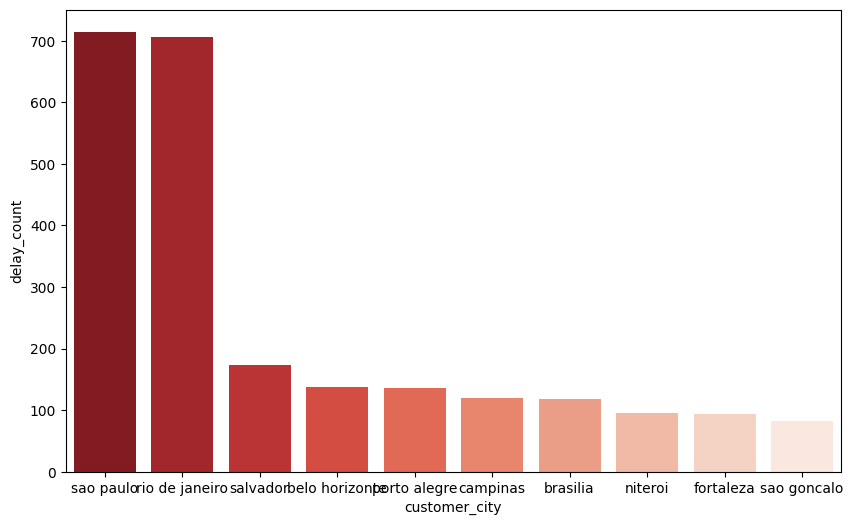

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.barplot(
    data=top_delayed_by_city,
    x='customer_city',
    y='delay_count',
    palette='Reds_r'
)

State of **Sao Paula** and **Rio de Janeiro** have the highest number of customers with late delivery

###Products Analysis

In [14]:
products.head()

,product_id,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm
0,1e9e8ef04dbcff4541ed26657ea517e5,perfumaria,40.0,287.0,1.0,225.0,16.0,10.0,14.0
1,3aa071139cb16b67ca9e5dea641aaa2f,artes,44.0,276.0,1.0,1000.0,30.0,18.0,20.0
2,96bd76ec8810374ed1b65e291975717f,esporte_lazer,46.0,250.0,1.0,154.0,18.0,9.0,15.0
3,cef67bcfe19066a932b7673e239eb23d,bebes,27.0,261.0,1.0,371.0,26.0,4.0,26.0
4,9dc1a7de274444849c219cff195d0b71,utilidades_domesticas,37.0,402.0,4.0,625.0,20.0,17.0,13.0


In [15]:
# Merged the Dataframes
items = order_items.merge(products,on='product_id')
items = items.merge(filtered_orders[['order_id','delayed']],on='order_id')
items.head()

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm,delayed
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.90,13.29,cool_stuff,58.0,598.0,4.0,650.0,28.0,9.0,14.0,False
1,00018f77f2f0320c557190d7a144bdd3,1,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,2017-05-03 11:05:13,239.90,19.93,pet_shop,56.0,239.0,2.0,30000.0,50.0,30.0,40.0,False
2,000229ec398224ef6ca0657da4fc703e,1,c777355d18b72b67abbeef9df44fd0fd,5b51032eddd242adc84c38acab88f23d,2018-01-18 14:48:30,199.00,17.87,moveis_decoracao,59.0,695.0,2.0,3050.0,33.0,13.0,33.0,False
3,00024acbcdf0a6daa1e931b038114c75,1,7634da152a4610f1595efa32f14722fc,9d7a1d34a5052409006425275ba1c2b4,2018-08-15 10:10:18,12.99,12.79,perfumaria,42.0,480.0,1.0,200.0,16.0,10.0,15.0,False
4,00042b26cf59d7ce69dfabb4e55b4fd9,1,ac6c3623068f30de03045865e4e10089,df560393f3a51e74553ab94004ba5c87,2017-02-13 13:57:51,199.90,18.14,ferramentas_jardim,59.0,409.0,1.0,3750.0,35.0,40.0,30.0,False


In [16]:
product_category_translation.head() #names

,product_category_name,product_category_name_english
0,beleza_saude,health_beauty
1,informatica_acessorios,computers_accessories
2,automotivo,auto
3,cama_mesa_banho,bed_bath_table
4,moveis_decoracao,furniture_decor


In [17]:
top_delayed_category = items.groupby('product_category_name')['delayed'].mean().sort_values(ascending=False).head(10)
top_delayed_category = top_delayed_category.reset_index()
top_delayed_category = top_delayed_category.merge(product_category_translation,on='product_category_name')
top_delayed_category = top_delayed_category[['product_category_name_english','delayed']]
top_delayed_category = top_delayed_category.sort_values(by='delayed',ascending=False)
top_delayed_category

,product_category_name_english,delayed
0,furniture_mattress_and_upholstery,0.135135
1,home_comfort_2,0.133333
2,audio,0.116022
3,christmas_supplies,0.100000
4,fashion_underwear_beach,0.094488
5,home_confort,0.093240
6,books_technical,0.079848
7,office_furniture,0.079736
8,baby,0.076794
9,electronics,0.075852


/tmp/ipython-input-802703752.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


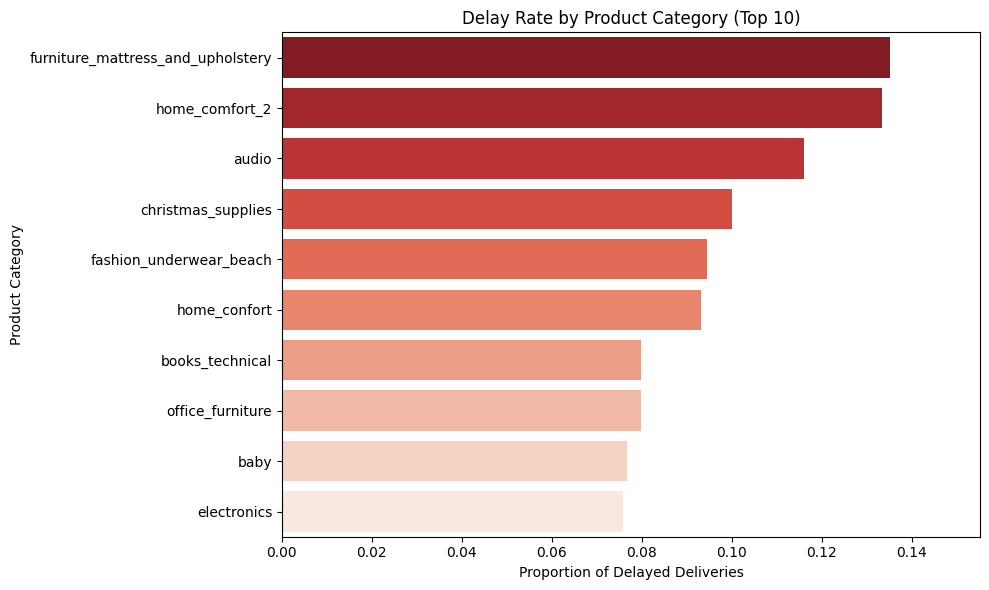

In [18]:
plt.figure(figsize=(10, 6))
sns.barplot(
    data=top_delayed_category,
    x='delayed',
    y='product_category_name_english',
    palette='Reds_r'
)

plt.xlabel("Proportion of Delayed Deliveries")
plt.ylabel("Product Category")
plt.title("Delay Rate by Product Category (Top 10)")
plt.xlim(0, top_delayed_category['delayed'].max() + 0.02)
plt.tight_layout()
plt.show()

From above graph , we can conclude that **Furniture Mattress, Upholstery and Home comforts** were most delayed

###Delivery and Logistic Analysis

In [19]:
order_customer_df.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,delivery_delay,delayed,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18,-8,False,7c396fd4830fd04220f754e42b4e5bff,3149,sao paulo,SP
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13,-6,False,af07308b275d755c9edb36a90c618231,47813,barreiras,BA
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04,-18,False,3a653a41f6f9fc3d2a113cf8398680e8,75265,vianopolis,GO
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15,-13,False,7c142cf63193a1473d2e66489a9ae977,59296,sao goncalo do amarante,RN
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26,-10,False,72632f0f9dd73dfee390c9b22eb56dd6,9195,santo andre,SP


In [20]:
delayed_matrix = order_customer_df.merge(order_items,on='order_id').merge(sellers,on='seller_id')
#Merged for comparing and matching

In [21]:
delayed_grouped = delayed_matrix.groupby(['customer_city','seller_city'])['delayed'].count().reset_index()
delayed_grouped

,customer_city,seller_city,delayed
0,abadia dos dourados,montenegro,1
1,abadia dos dourados,rio de janeiro,1
2,abadia dos dourados,sao paulo,1
3,abadiania,sao paulo,1
4,abaete,bauru,1
...,...,...,...
35624,ze doca,maringa,1
35625,ze doca,sao paulo,2
35626,ze doca,sao roque,1
35627,zortea,sao paulo,1


In [22]:
delayed_grouped = delayed_grouped.sort_values(by='delayed',ascending=False).head(20)
delayed_grouped #Top 20

,customer_city,seller_city,delayed
31027,sao paulo,sao paulo,4674
26563,rio de janeiro,sao paulo,1597
30837,sao paulo,ibitinga,1322
3641,belo horizonte,sao paulo,679
26401,rio de janeiro,ibitinga,581
4707,brasilia,sao paulo,521
31004,sao paulo,santo andre,477
9548,curitiba,sao paulo,409
30788,sao paulo,curitiba,409
6021,campinas,sao paulo,408


In [23]:
delayed_grouped['city_pair'] = delayed_grouped['seller_city'] + " ➞ " + delayed_grouped['customer_city']
#Mapping

/tmp/ipython-input-1877862937.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=delayed_grouped, x='delayed', y='city_pair', palette='Reds_r')


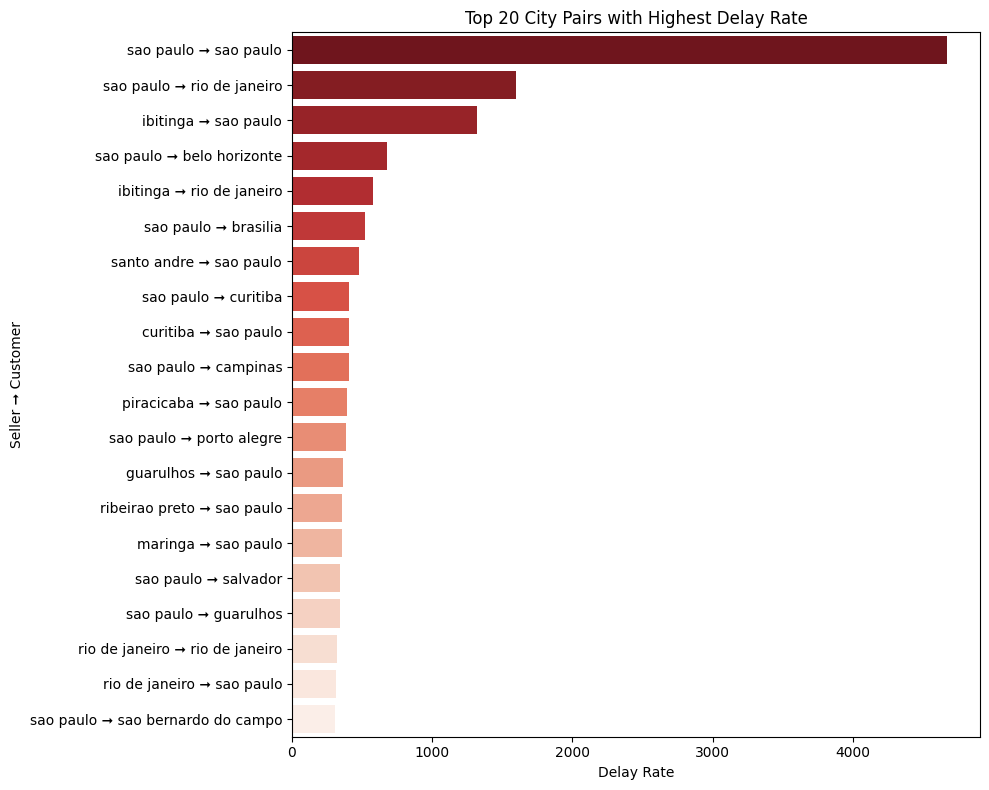

In [24]:
plt.figure(figsize=(10, 8))
sns.barplot(data=delayed_grouped, x='delayed', y='city_pair', palette='Reds_r')
plt.title('Top 20 City Pairs with Highest Delay Rate')
plt.xlabel('Delay Rate')
plt.ylabel('Seller ➞ Customer')
plt.tight_layout()
plt.show()

###**Payment Analysis**

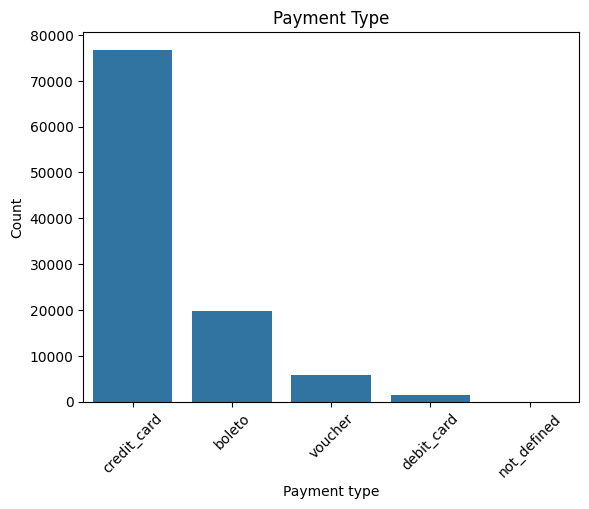

In [25]:
sns.countplot(data=order_payments,x=order_payments['payment_type'],order=order_payments['payment_type'].value_counts().index)
plt.title('Payment Type')
plt.xlabel('Payment type')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

Maximum transactions are done by **Credit card**

###**Review Analysis**

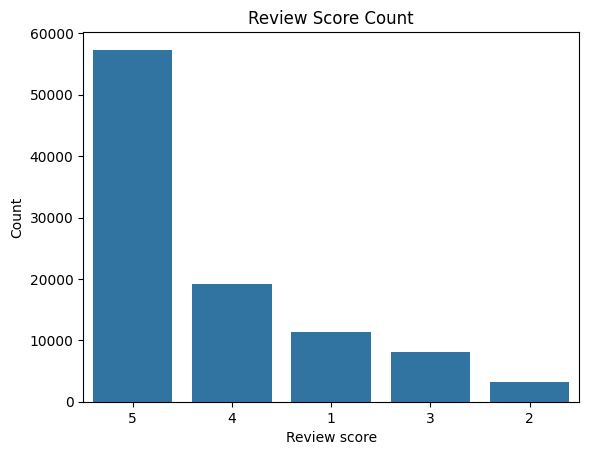

In [26]:
sns.countplot(x=order_reviews['review_score'],order=order_reviews['review_score'].value_counts().index)
plt.title('Review Score Count')
plt.xlabel('Review score')
plt.ylabel('Count')
plt.show()

###**Feature Engineering**

In [40]:
# Merging the datasets
df_merged = pd.merge(orders, customers, on='customer_id')
df_merged = pd.merge(df_merged, order_items, on='order_id')
df_merged = pd.merge(df_merged, products, on='product_id')
df_merged = pd.merge(df_merged, sellers, on='seller_id')
df_merged = pd.merge(df_merged, order_payments, on='order_id')


In [41]:
df_merged['order_purchase_timestamp'] = pd.to_datetime(df_merged['order_purchase_timestamp'])
df_merged['order_estimated_delivery_date'] = pd.to_datetime(df_merged['order_estimated_delivery_date'])
df_merged['order_delivered_customer_date'] = pd.to_datetime(df_merged['order_delivered_customer_date'])
df_merged.dropna(subset=['order_delivered_customer_date'], inplace=True)

In [42]:
#Target Variable
df_merged['is_delayed'] = (df_merged['order_delivered_customer_date'] > df_merged['order_estimated_delivery_date']).astype(int)

In [37]:
#Predictor Features
df_merged['purchase_day_of_week'] = df_merged['order_purchase_timestamp'].dt.dayofweek
df_merged['purchase_month'] = df_merged['order_purchase_timestamp'].dt.month
df_merged['shipping_lead_time_days'] = (df_merged['order_estimated_delivery_date'] - df_merged['order_purchase_timestamp']).dt.days

In [43]:
df_merged['product_weight_kg'] = df_merged['product_weight_g'] / 1000
df_merged['volume_cm3'] = df_merged['product_length_cm'] * df_merged['product_height_cm'] * df_merged['product_width_cm']

In [44]:
df_processed = pd.get_dummies(df_merged, columns=['product_category_name', 'customer_state', 'seller_state', 'payment_type'], drop_first=True)

##**Model Building**

###**Training the model**

In [47]:
from sklearn.model_selection import train_test_split

features = [col for col in df_processed.columns if col not in [
    'is_delayed',
    'order_id',
    'customer_id',
    'customer_unique_id',
    'product_id',
    'seller_id',
    'customer_city',
    'seller_city',
    'order_status',
    'order_purchase_timestamp',
    'order_approved_at',
    'order_delivered_carrier_date',
    'order_delivered_customer_date',
    'order_estimated_delivery_date',
    'shipping_limit_date'
]]
X = df_processed[features]
y = df_processed['is_delayed']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [48]:
#Gradient Boost

import xgboost as xgb
model = xgb.XGBClassifier(objective='binary:logistic', eval_metric='logloss')
model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, ...)

###**Model Evaluation**

In [49]:
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix
y_pred_proba = model.predict_proba(X_test)[:, 1]
y_pred = (y_pred_proba > 0.5).astype(int)

In [50]:
print("ROC AUC Score:", roc_auc_score(y_test, y_pred_proba))

ROC AUC Score: 0.719470945745201


In [51]:
print("Classification Report:\n", classification_report(y_test, y_pred))

Classification Report:
               precision    recall  f1-score   support

           0       0.92      1.00      0.96     21202
           1       0.74      0.04      0.07      1805

    accuracy                           0.92     23007
   macro avg       0.83      0.52      0.52     23007
weighted avg       0.91      0.92      0.89     23007



In [52]:
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

Confusion Matrix:
 [[21179    23]
 [ 1738    67]]


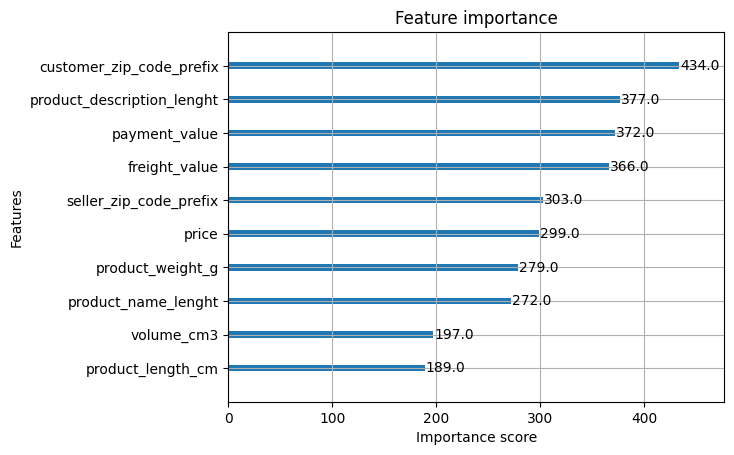

In [53]:
import matplotlib.pyplot as plt
xgb.plot_importance(model, max_num_features=10)
plt.show()

**This analysis of the Olist e-commerce is providing valuable insights into shipping performance and delivery delays:**

1. Around 6–7% of all orders are delayed, with Sao Paulo and Rio de
Janeiro being the most affected cities.

2. Certain product categories, such as Furniture Mattress and Upholstery, show significantly higher delay rates.

3. Logistic inefficiencies often occur in specific seller–customer city routes, highlighting areas for supply chain optimization.

4. Payment analysis indicates that credit cards dominate transactions, while review scores reflect varied customer experiences.